In [4]:
#%%
# modules
import yaml
from dataclasses import dataclass
from pathlib import Path
import proplot as pplt

import numpy as np
import torch
from torch.utils.data import DataLoader

from model.network import DeepSparser
from dataset.dataset_synthetic import TrainDataset, TestDataset


# config
@dataclass
class Config:
    dct_width: int = 256                                    # width of signal window for dct
    dct_stride_percent:float = 0.3
    dct_stride: int = int(dct_width*dct_stride_percent)     # stride of signal window for dct
    embed_dim: int = 256                                    # dimension of embedding
    patch_n: int = 15                                       # number of segments of one patch
    dae_dims = [32, 64, 128, 256, 128, 64, 32, 16]          # dimensions of DAE
    init_embedding: bool = True
    fix_embedding: bool = False   
    embed_loss_weight: bool = 0.1        
    batchsize: int = 32                                     # batch size for training
    lr: float = 1e-2                                        # initial learning rate
    epochs: int = 2000                                      # number of epochs for training
    scheduler_step: float = epochs//100                     # step size for learning rate scheduler
    scheduler_gamma:float = 0.95                            # gamma for learning rate scheduler
    data_path: str =None
    checkpoint_path: str=None
config = Config(**yaml.load(open('config/config_synthetic.yaml', 'r', encoding='utf-8'), Loader=yaml.FullLoader ))


## train

In [ ]:
if not Path(config.checkpoint_path).exists():

    # data
    train_data = np.load(Path(config.data_path) / 'training_data.npz')
    signal, noise = train_data['x'], train_data['n']
    trainloader = DataLoader(TrainDataset(signal, noise, config), batch_size=config.batchsize, shuffle=True)

    # model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DeepSparser(config).to(device)
    optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad, model.parameters()),lr=config.lr)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=config.scheduler_step, gamma = config.scheduler_gamma)


    # train
    epoch_losses = []
    for epoch in range(config.epochs):
        model.train()
        batch_losses = []
        for i, (s, y) in enumerate(trainloader):
            s, y = s.to(device), y.to(device)
            loss = model.trainloss(y, s, config.embed_loss_weight)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        epoch_losses.append(np.mean(batch_losses))
        lr_scheduler.step()

    # save
    torch.save(model.state_dict(), Path(config.checkpoint_path))


## inference

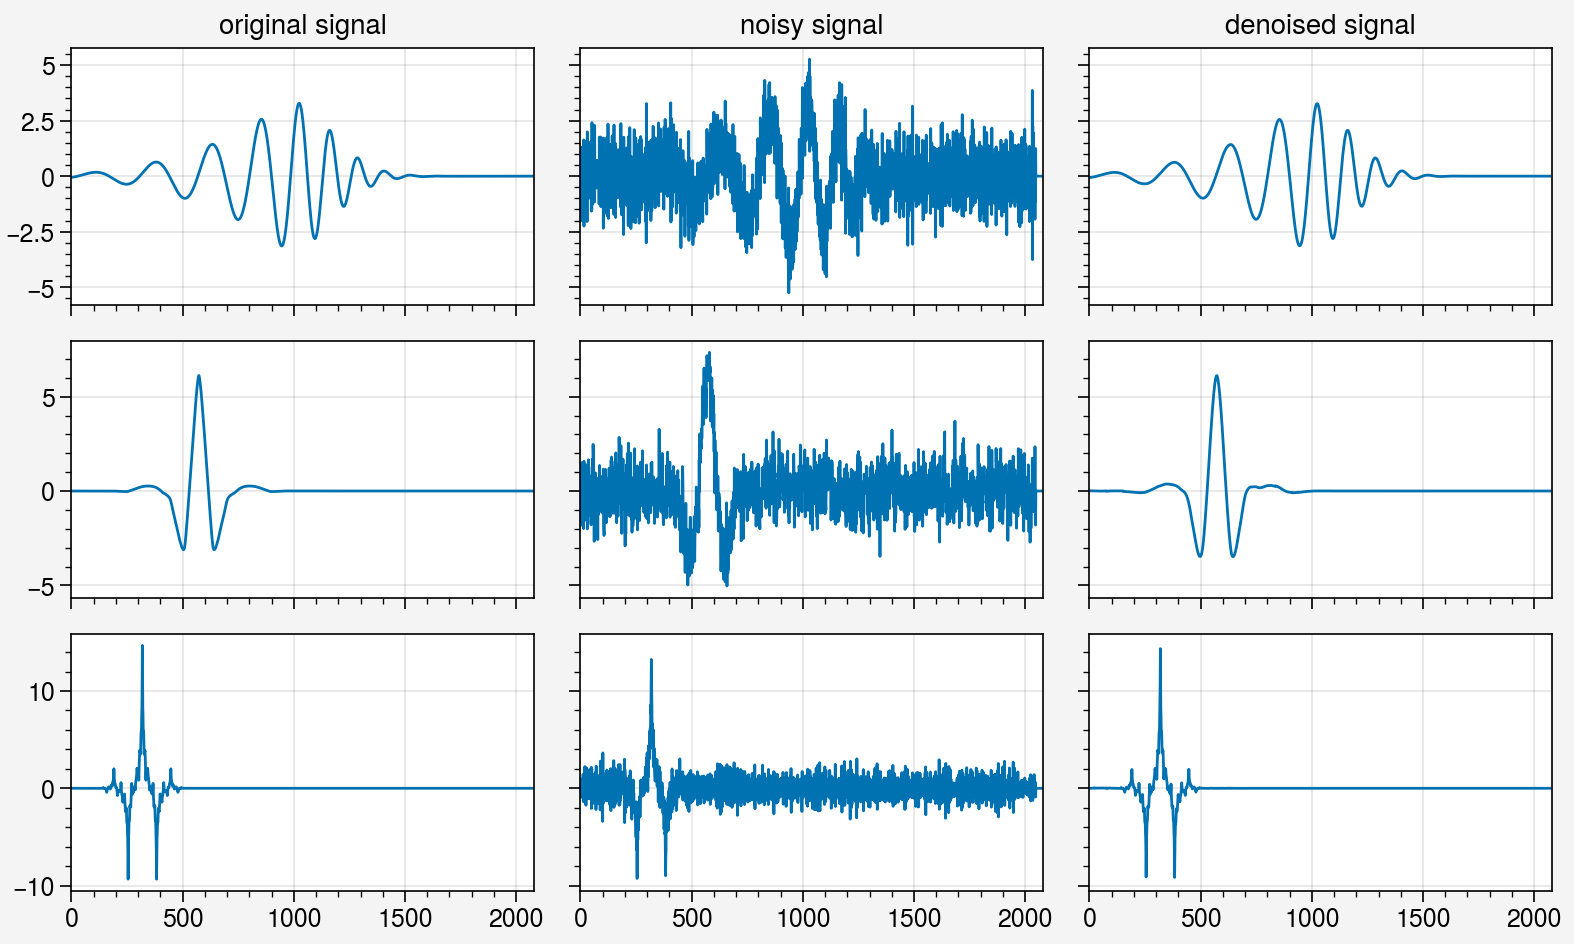

In [9]:
# data
test_data = np.load(Path(config.data_path) / 'testing_data.npz')
signal, noise = test_data['x'], test_data['n']
test_data = TestDataset(signal, noise, config)

# model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DeepSparser(config).to(device)
model.eval()
model.load_state_dict(torch.load(Path(config.checkpoint_path), map_location=device))


indexs = [10, 20, 30]
fig = pplt.figure(width='20cm', height=f'{4*len(indexs)}cm')
ax = fig.subplots(np.arange(1,3*len(indexs)+1).reshape(-1,3))
for i, index in enumerate(indexs):

    s, n = test_data[index]
    y = test_data.add_certain_noise(s, n, 0)
    s_hat = model.denoise(y)
    ax[i*3].plot(s, lw=1)
    ax[i*3+1].plot(y, lw=1)
    ax[i*3+2].plot(s_hat, lw=1)


ax[0].format(title='original signal')
ax[1].format(title='noisy signal')
ax[2].format(title='denoised signal')